In [123]:
! pip install tensorflow tqdm


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [124]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [125]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [126]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

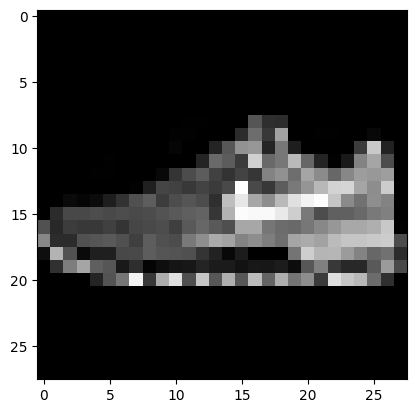

In [127]:
train_images = (train_images - 127.5) / 127.5
plt.imshow(train_images[2567].squeeze(), cmap="gray")

In [128]:
buffer_size: int = 60000
batch_size: int = 128

In [129]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [130]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim = 100))
    model.add(layers.ReLU())
    
    model.add(layers.Dense(128))
    model.add(layers.ReLU())
    
    model.add(layers.Dense(256))
    model.add(layers.ReLU())
    
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    
    return model

generator = generator_model()
generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 64)                6464      
                                                                 
 re_lu_17 (ReLU)             (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 128)               8320      
                                                                 
 re_lu_18 (ReLU)             (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 256)               33024     
                                                                 
 re_lu_19 (ReLU)             (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 784)             

In [131]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image.shape

TensorShape([1, 28, 28, 1])

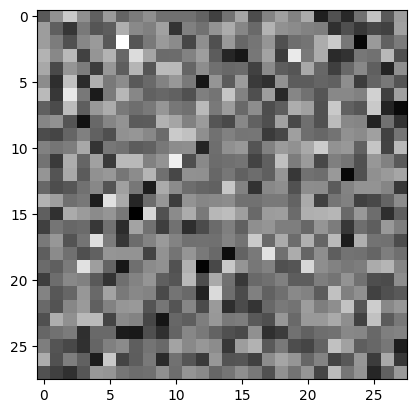

In [132]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [133]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    
    return model

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_51 (Dense)            (None, 256)               200960    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_52 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 128)               0         
                                                                 
 dropout_19 (Dropout)        (None, 128)             

In [134]:
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.48178953]], shape=(1, 1), dtype=float32)


In [135]:
bce = tf.keras.losses.BinaryCrossentropy()

In [136]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [137]:
generator_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [138]:
checkpoint_dir = "data-nn-gan/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_opt,
                                 discriminator_optimizer = discriminator_opt,
                                 generator=generator,
                                 discriminator=discriminator
                                 )

In [139]:
from numpy import number


epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [140]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
    
    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [141]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(8, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap="gray")
        plt.axis('off')
    
    plt.savefig('data-nn-gan/images/image_at_epoch {:04d}.png'.format(epoch))
    plt.show()

In [142]:
from sklearn.model_selection import train_test_split


def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        
        num_batches = len(dataset)
        
        print(f"Training started with epoch {epoch+1} with {num_batches} batches...")
        
        total_gen_loss, total_disc_loss = 0, 0
        
        for batch in dataset:
            gen_loss, disc_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
        
        print(f"Epoch: {epoch+1}: Generator loss: {gen_loss: 3f}, Discriminator loss: {disc_loss: 3f}, Real Score: {real_score: 3f}. Fake Score: {fake_score: 3f}")
        
        generate_and_plot_images(generator, epoch+1, seed)
        
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)
        
        if (epoch+1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Time for epoch: {epoch+1} is {time.time() - start} seconds")
        
    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list
        

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches...
Epoch: 1: Generator loss:  4.120702, Discriminator loss:  0.200159, Real Score:  0.960114. Fake Score:  0.112459


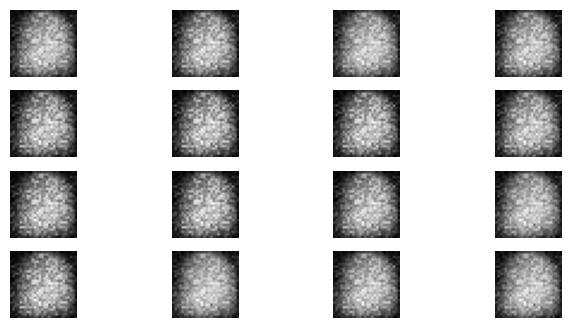

  2%|▏         | 1/50 [00:06<05:23,  6.60s/it]

Time for epoch: 1 is 6.601104736328125 seconds
Training started with epoch 2 with 469 batches...
Epoch: 2: Generator loss:  4.632379, Discriminator loss:  0.033897, Real Score:  0.992479. Fake Score:  0.020106


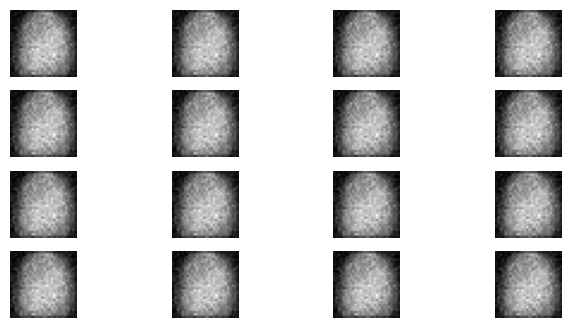

  4%|▍         | 2/50 [00:11<04:42,  5.88s/it]

Time for epoch: 2 is 5.370639801025391 seconds
Training started with epoch 3 with 469 batches...
Epoch: 3: Generator loss:  2.803262, Discriminator loss:  0.363462, Real Score:  0.905405. Fake Score:  0.111106


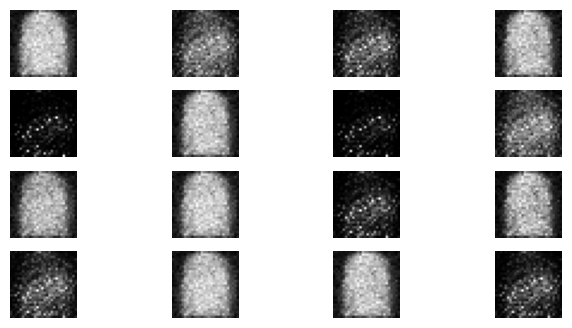

  6%|▌         | 3/50 [00:16<04:14,  5.42s/it]

Time for epoch: 3 is 4.873991966247559 seconds
Training started with epoch 4 with 469 batches...
Epoch: 4: Generator loss:  2.239300, Discriminator loss:  0.368978, Real Score:  0.892213. Fake Score:  0.172744


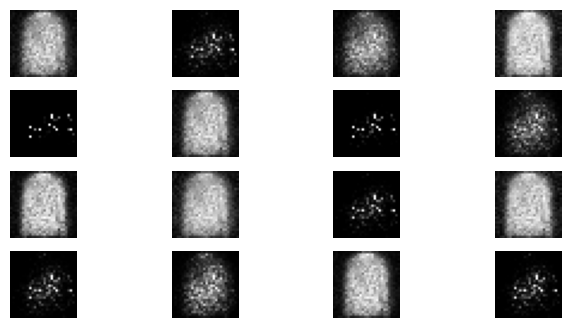

  8%|▊         | 4/50 [00:23<04:22,  5.71s/it]

Time for epoch: 4 is 6.1540186405181885 seconds
Training started with epoch 5 with 469 batches...
Epoch: 5: Generator loss:  2.804151, Discriminator loss:  0.586242, Real Score:  0.827990. Fake Score:  0.156274


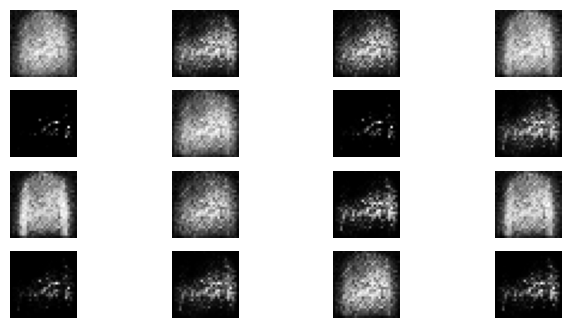

 10%|█         | 5/50 [00:28<04:10,  5.57s/it]

Time for epoch: 5 is 5.328046798706055 seconds
Training started with epoch 6 with 469 batches...
Epoch: 6: Generator loss:  1.991780, Discriminator loss:  0.746898, Real Score:  0.811350. Fake Score:  0.221458


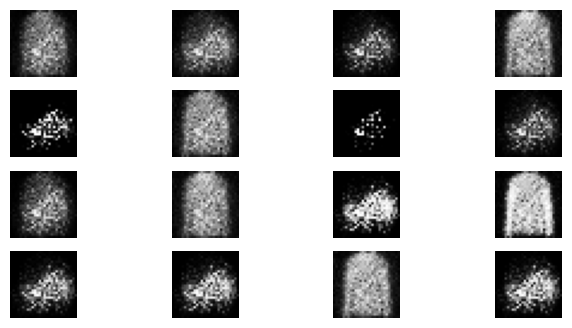

 12%|█▏        | 6/50 [00:35<04:31,  6.16s/it]

Time for epoch: 6 is 7.310024738311768 seconds
Training started with epoch 7 with 469 batches...
Epoch: 7: Generator loss:  2.515026, Discriminator loss:  0.567507, Real Score:  0.851519. Fake Score:  0.187304


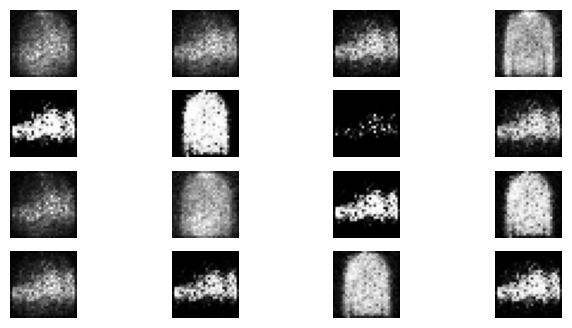

 14%|█▍        | 7/50 [00:42<04:27,  6.23s/it]

Time for epoch: 7 is 6.343343734741211 seconds
Training started with epoch 8 with 469 batches...
Epoch: 8: Generator loss:  2.877312, Discriminator loss:  0.474507, Real Score:  0.844274. Fake Score:  0.129699


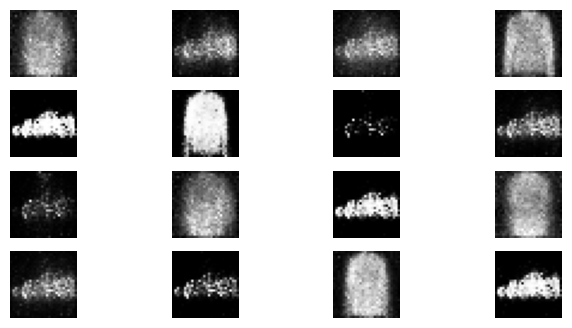

 16%|█▌        | 8/50 [00:48<04:23,  6.28s/it]

Time for epoch: 8 is 6.400016784667969 seconds
Training started with epoch 9 with 469 batches...
Epoch: 9: Generator loss:  2.315886, Discriminator loss:  0.633224, Real Score:  0.828535. Fake Score:  0.199794


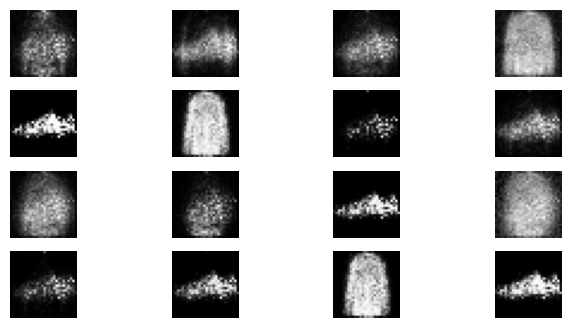

 18%|█▊        | 9/50 [00:54<04:21,  6.38s/it]

Time for epoch: 9 is 6.578994512557983 seconds
Training started with epoch 10 with 469 batches...
Epoch: 10: Generator loss:  2.750510, Discriminator loss:  0.467025, Real Score:  0.843456. Fake Score:  0.162179


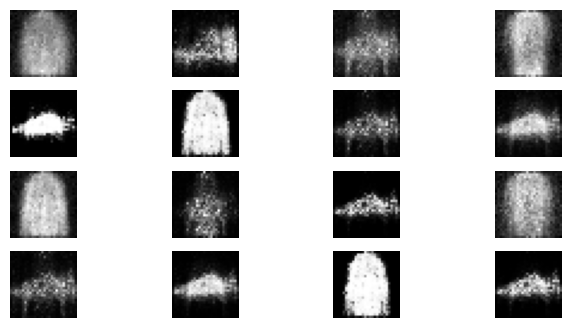

 20%|██        | 10/50 [01:01<04:11,  6.29s/it]

Time for epoch: 10 is 6.083430290222168 seconds
Training started with epoch 11 with 469 batches...
Epoch: 11: Generator loss:  2.453692, Discriminator loss:  0.611244, Real Score:  0.859638. Fake Score:  0.192637


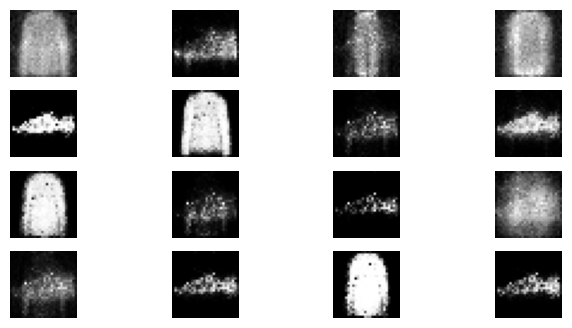

 22%|██▏       | 11/50 [01:07<04:03,  6.23s/it]

Time for epoch: 11 is 6.11797571182251 seconds
Training started with epoch 12 with 469 batches...
Epoch: 12: Generator loss:  1.910360, Discriminator loss:  0.737645, Real Score:  0.811986. Fake Score:  0.239725


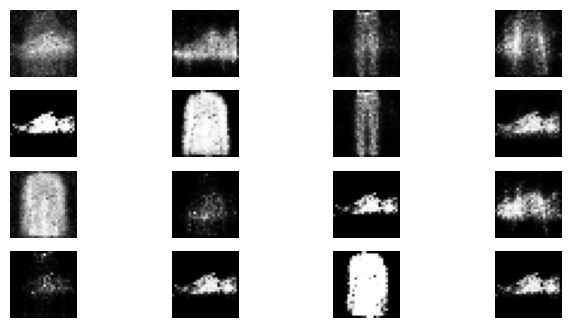

 24%|██▍       | 12/50 [01:12<03:51,  6.10s/it]

Time for epoch: 12 is 5.7945520877838135 seconds
Training started with epoch 13 with 469 batches...
Epoch: 13: Generator loss:  2.224017, Discriminator loss:  0.611215, Real Score:  0.780151. Fake Score:  0.195268


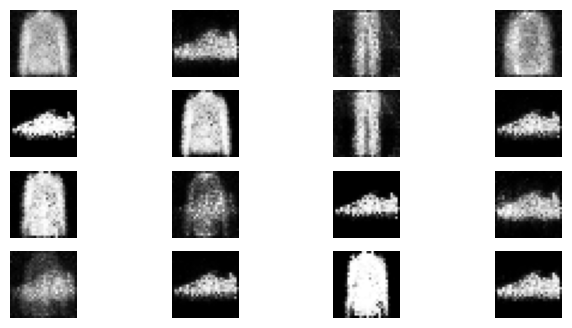

 26%|██▌       | 13/50 [01:19<03:48,  6.19s/it]

Time for epoch: 13 is 6.39021372795105 seconds
Training started with epoch 14 with 469 batches...
Epoch: 14: Generator loss:  2.036440, Discriminator loss:  0.760232, Real Score:  0.801923. Fake Score:  0.212321


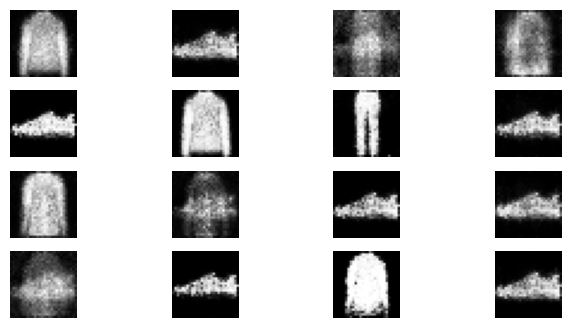

 28%|██▊       | 14/50 [01:24<03:33,  5.94s/it]

Time for epoch: 14 is 5.364159345626831 seconds
Training started with epoch 15 with 469 batches...
Epoch: 15: Generator loss:  2.520587, Discriminator loss:  0.723817, Real Score:  0.773063. Fake Score:  0.163752


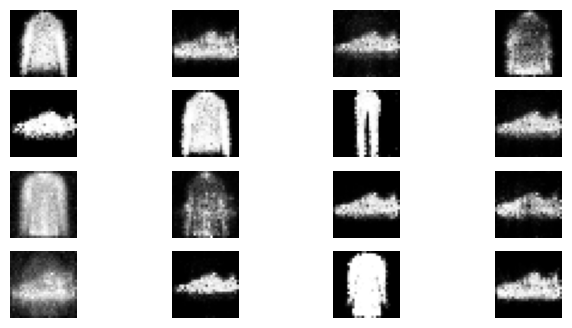

 30%|███       | 15/50 [01:30<03:21,  5.75s/it]

Time for epoch: 15 is 5.313434362411499 seconds
Training started with epoch 16 with 469 batches...
Epoch: 16: Generator loss:  1.381256, Discriminator loss:  0.929391, Real Score:  0.799728. Fake Score:  0.362034


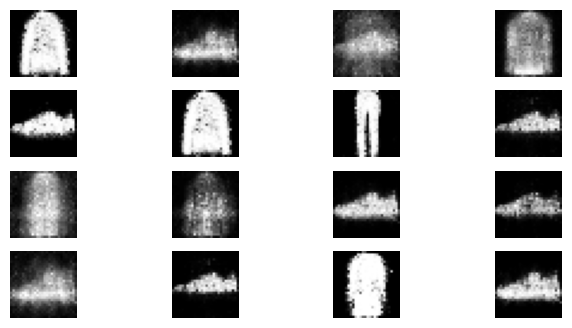

 32%|███▏      | 16/50 [01:35<03:09,  5.57s/it]

Time for epoch: 16 is 5.140923261642456 seconds
Training started with epoch 17 with 469 batches...
Epoch: 17: Generator loss:  1.675441, Discriminator loss:  0.674835, Real Score:  0.778455. Fake Score:  0.240918


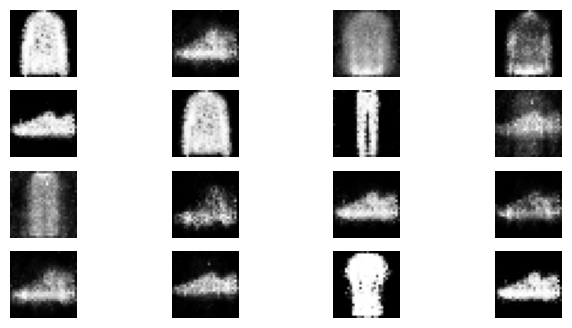

 34%|███▍      | 17/50 [01:40<03:00,  5.47s/it]

Time for epoch: 17 is 5.245846748352051 seconds
Training started with epoch 18 with 469 batches...
Epoch: 18: Generator loss:  2.348017, Discriminator loss:  0.697705, Real Score:  0.785907. Fake Score:  0.205050


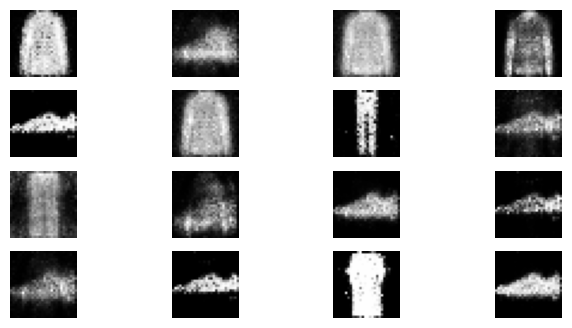

 36%|███▌      | 18/50 [01:45<02:52,  5.39s/it]

Time for epoch: 18 is 5.208393573760986 seconds
Training started with epoch 19 with 469 batches...
Epoch: 19: Generator loss:  1.642793, Discriminator loss:  0.754008, Real Score:  0.788094. Fake Score:  0.251314


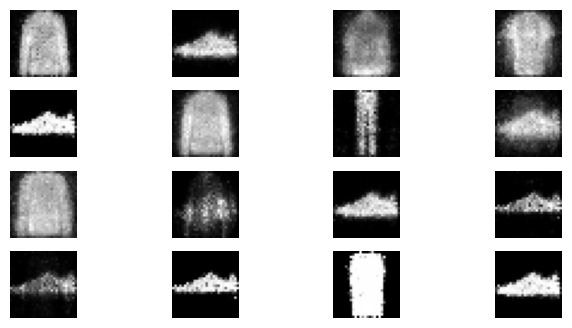

 38%|███▊      | 19/50 [01:51<02:50,  5.51s/it]

Time for epoch: 19 is 5.7925684452056885 seconds
Training started with epoch 20 with 469 batches...
Epoch: 20: Generator loss:  2.213019, Discriminator loss:  0.717620, Real Score:  0.752008. Fake Score:  0.204143


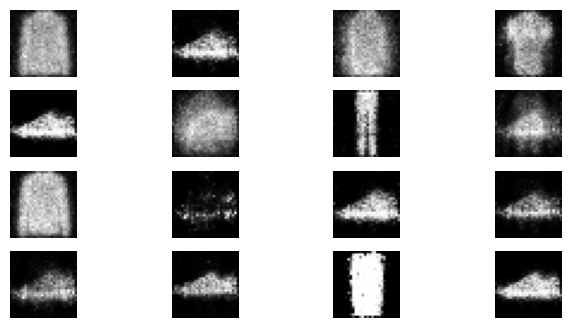

 40%|████      | 20/50 [01:56<02:45,  5.51s/it]

Time for epoch: 20 is 5.506319761276245 seconds
Training started with epoch 21 with 469 batches...
Epoch: 21: Generator loss:  4.343175, Discriminator loss:  0.442412, Real Score:  0.828262. Fake Score:  0.108374


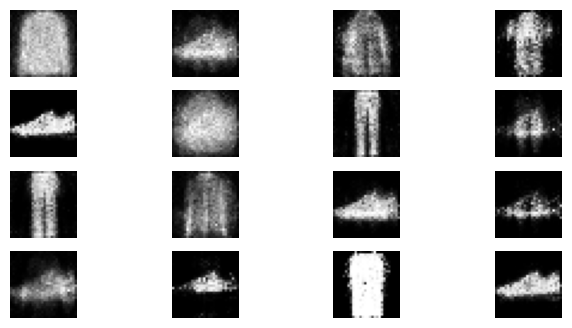

 42%|████▏     | 21/50 [02:02<02:37,  5.44s/it]

Time for epoch: 21 is 5.283295631408691 seconds
Training started with epoch 22 with 469 batches...
Epoch: 22: Generator loss:  2.100427, Discriminator loss:  0.687868, Real Score:  0.804799. Fake Score:  0.202050


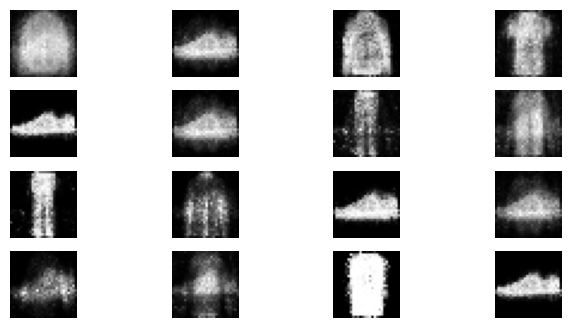

 44%|████▍     | 22/50 [02:07<02:34,  5.52s/it]

Time for epoch: 22 is 5.696707248687744 seconds
Training started with epoch 23 with 469 batches...
Epoch: 23: Generator loss:  1.975537, Discriminator loss:  0.649339, Real Score:  0.879272. Fake Score:  0.243417


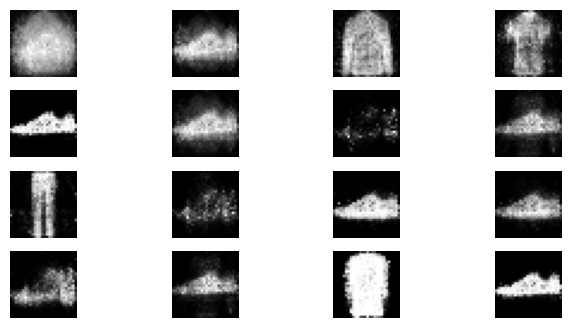

 46%|████▌     | 23/50 [02:13<02:29,  5.55s/it]

Time for epoch: 23 is 5.612857341766357 seconds
Training started with epoch 24 with 469 batches...
Epoch: 24: Generator loss:  1.919224, Discriminator loss:  0.928259, Real Score:  0.797711. Fake Score:  0.275762


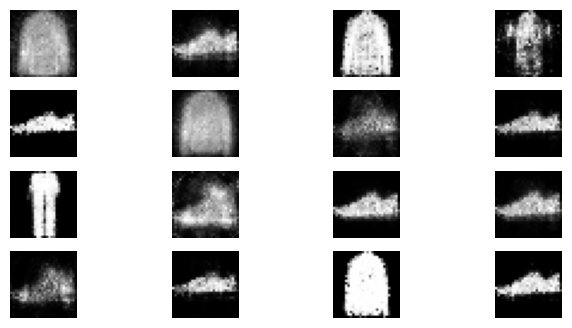

 48%|████▊     | 24/50 [02:18<02:21,  5.45s/it]

Time for epoch: 24 is 5.217639923095703 seconds
Training started with epoch 25 with 469 batches...
Epoch: 25: Generator loss:  1.874355, Discriminator loss:  0.885523, Real Score:  0.685527. Fake Score:  0.229654


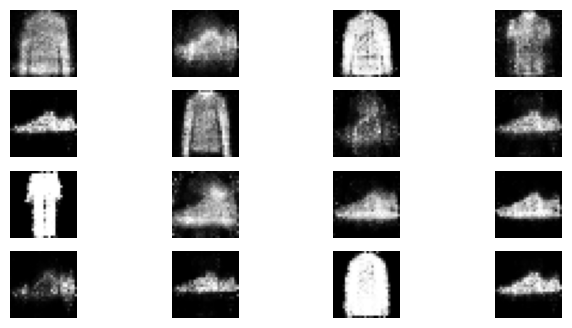

 50%|█████     | 25/50 [02:24<02:16,  5.45s/it]

Time for epoch: 25 is 5.454919815063477 seconds
Training started with epoch 26 with 469 batches...
Epoch: 26: Generator loss:  2.311100, Discriminator loss:  0.497262, Real Score:  0.891787. Fake Score:  0.194568


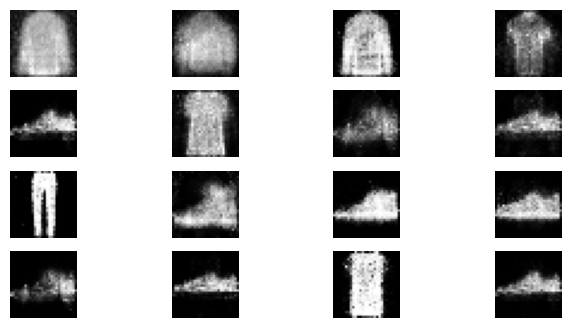

 52%|█████▏    | 26/50 [02:30<02:15,  5.64s/it]

Time for epoch: 26 is 6.076521873474121 seconds
Training started with epoch 27 with 469 batches...
Epoch: 27: Generator loss:  2.254058, Discriminator loss:  0.604840, Real Score:  0.767004. Fake Score:  0.185148


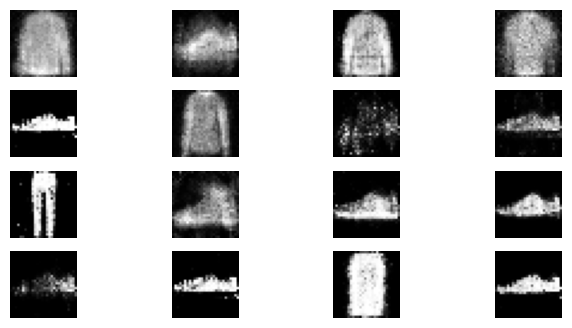

 54%|█████▍    | 27/50 [02:35<02:08,  5.57s/it]

Time for epoch: 27 is 5.408227920532227 seconds
Training started with epoch 28 with 469 batches...
Epoch: 28: Generator loss:  2.167181, Discriminator loss:  0.953033, Real Score:  0.686299. Fake Score:  0.218692


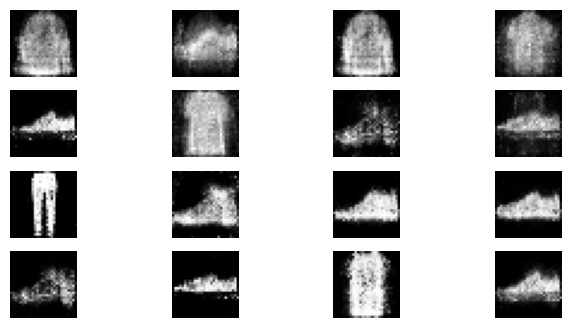

 56%|█████▌    | 28/50 [02:41<02:02,  5.57s/it]

Time for epoch: 28 is 5.560782432556152 seconds
Training started with epoch 29 with 469 batches...
Epoch: 29: Generator loss:  2.478955, Discriminator loss:  0.788377, Real Score:  0.767010. Fake Score:  0.205241


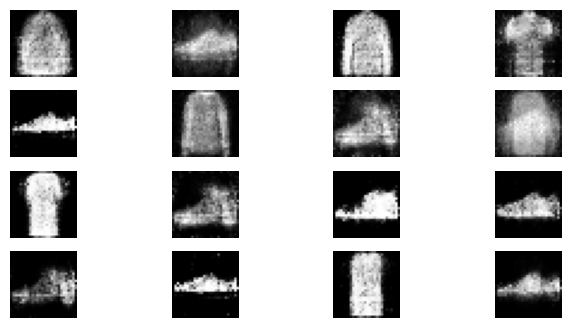

 58%|█████▊    | 29/50 [02:46<01:57,  5.61s/it]

Time for epoch: 29 is 5.716308355331421 seconds
Training started with epoch 30 with 469 batches...
Epoch: 30: Generator loss:  1.759979, Discriminator loss:  0.969235, Real Score:  0.765228. Fake Score:  0.282496


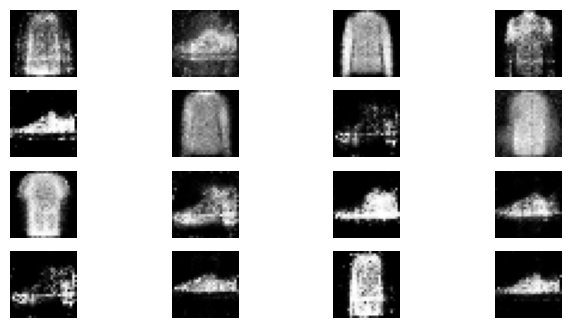

 60%|██████    | 30/50 [02:52<01:53,  5.66s/it]

Time for epoch: 30 is 5.771785020828247 seconds
Training started with epoch 31 with 469 batches...
Epoch: 31: Generator loss:  2.102541, Discriminator loss:  0.707152, Real Score:  0.828148. Fake Score:  0.220460


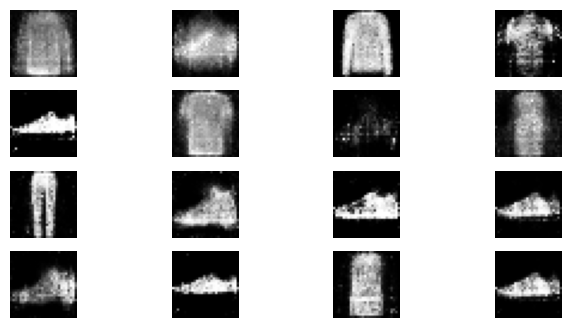

 62%|██████▏   | 31/50 [02:58<01:45,  5.56s/it]

Time for epoch: 31 is 5.323699235916138 seconds
Training started with epoch 32 with 469 batches...
Epoch: 32: Generator loss:  2.056253, Discriminator loss:  0.675397, Real Score:  0.763946. Fake Score:  0.204028


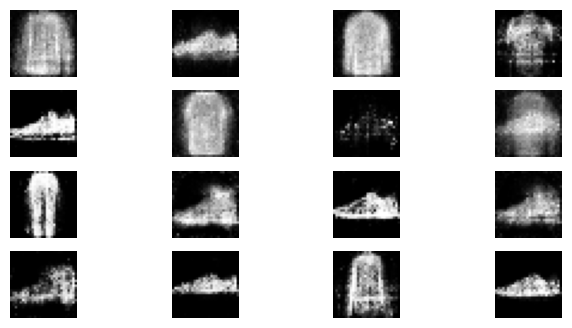

 64%|██████▍   | 32/50 [03:03<01:38,  5.47s/it]

Time for epoch: 32 is 5.271115779876709 seconds
Training started with epoch 33 with 469 batches...
Epoch: 33: Generator loss:  2.189599, Discriminator loss:  0.667537, Real Score:  0.745605. Fake Score:  0.188419


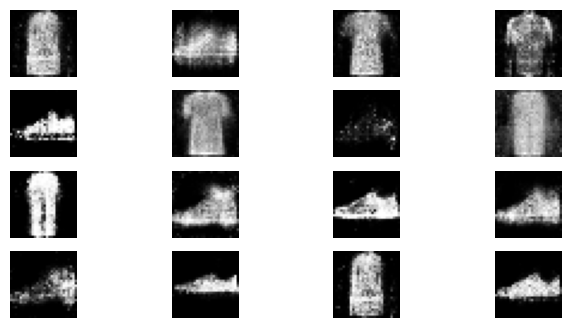

 66%|██████▌   | 33/50 [03:09<01:34,  5.59s/it]

Time for epoch: 33 is 5.849648475646973 seconds
Training started with epoch 34 with 469 batches...
Epoch: 34: Generator loss:  1.562638, Discriminator loss:  0.805924, Real Score:  0.709466. Fake Score:  0.266182


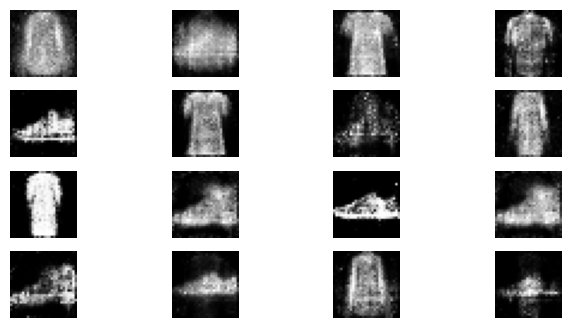

 68%|██████▊   | 34/50 [03:14<01:29,  5.60s/it]

Time for epoch: 34 is 5.644444704055786 seconds
Training started with epoch 35 with 469 batches...
Epoch: 35: Generator loss:  1.510363, Discriminator loss:  0.808452, Real Score:  0.740371. Fake Score:  0.292065


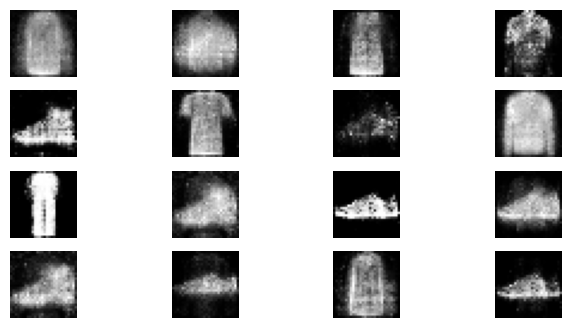

 70%|███████   | 35/50 [03:20<01:22,  5.52s/it]

Time for epoch: 35 is 5.330275058746338 seconds
Training started with epoch 36 with 469 batches...
Epoch: 36: Generator loss:  2.340522, Discriminator loss:  1.129653, Real Score:  0.670698. Fake Score:  0.219925


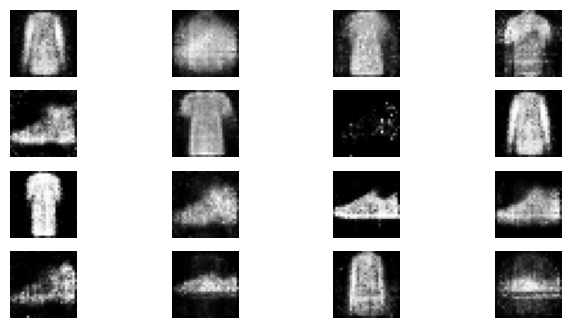

 72%|███████▏  | 36/50 [03:25<01:16,  5.50s/it]

Time for epoch: 36 is 5.440935850143433 seconds
Training started with epoch 37 with 469 batches...
Epoch: 37: Generator loss:  1.641569, Discriminator loss:  0.883312, Real Score:  0.702922. Fake Score:  0.275182


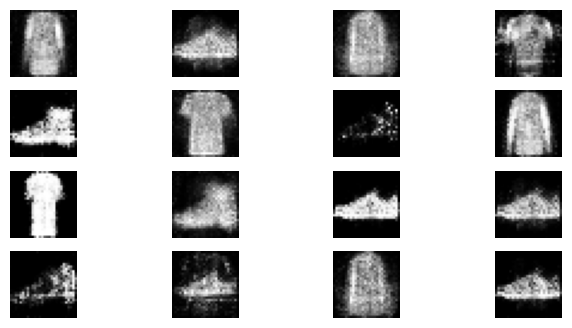

 74%|███████▍  | 37/50 [03:30<01:10,  5.45s/it]

Time for epoch: 37 is 5.333717107772827 seconds
Training started with epoch 38 with 469 batches...
Epoch: 38: Generator loss:  1.612578, Discriminator loss:  0.800088, Real Score:  0.766505. Fake Score:  0.264899


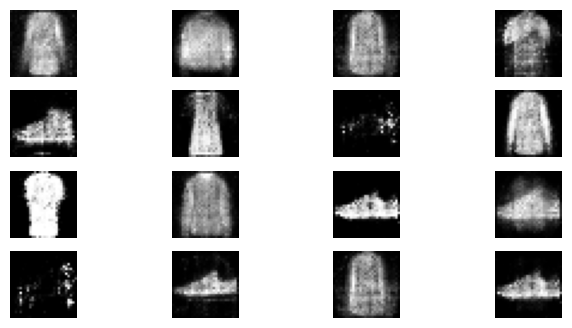

 76%|███████▌  | 38/50 [03:36<01:04,  5.39s/it]

Time for epoch: 38 is 5.260237455368042 seconds
Training started with epoch 39 with 469 batches...
Epoch: 39: Generator loss:  1.788613, Discriminator loss:  0.632195, Real Score:  0.829372. Fake Score:  0.252093


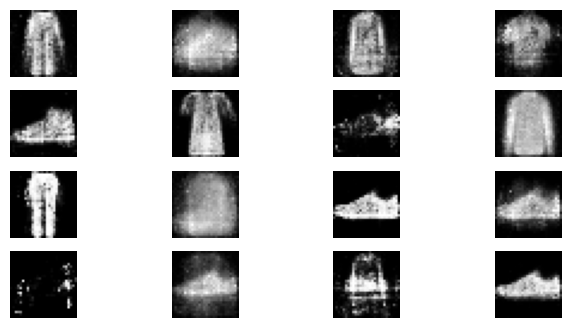

 78%|███████▊  | 39/50 [03:41<00:58,  5.35s/it]

Time for epoch: 39 is 5.237477540969849 seconds
Training started with epoch 40 with 469 batches...
Epoch: 40: Generator loss:  2.049779, Discriminator loss:  0.671105, Real Score:  0.769585. Fake Score:  0.206554


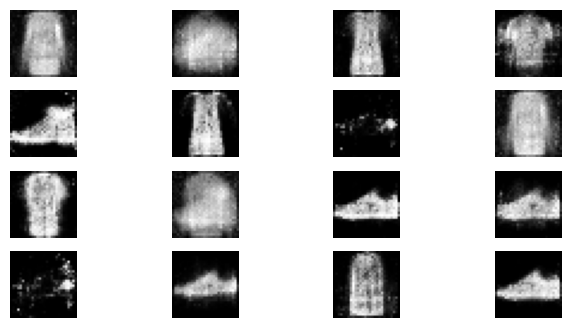

 80%|████████  | 40/50 [03:47<00:56,  5.63s/it]

Time for epoch: 40 is 6.29679012298584 seconds
Training started with epoch 41 with 469 batches...
Epoch: 41: Generator loss:  2.669207, Discriminator loss:  0.676639, Real Score:  0.725695. Fake Score:  0.139556


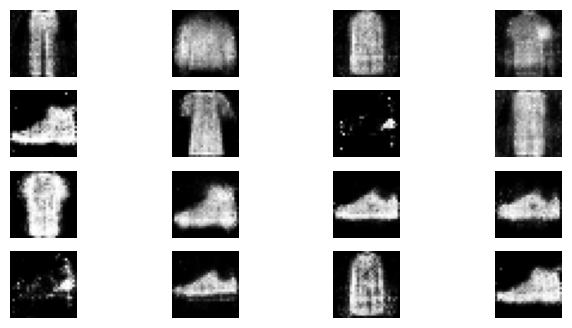

 82%|████████▏ | 41/50 [03:53<00:52,  5.80s/it]

Time for epoch: 41 is 6.196576356887817 seconds
Training started with epoch 42 with 469 batches...
Epoch: 42: Generator loss:  1.919979, Discriminator loss:  0.942250, Real Score:  0.772080. Fake Score:  0.283178


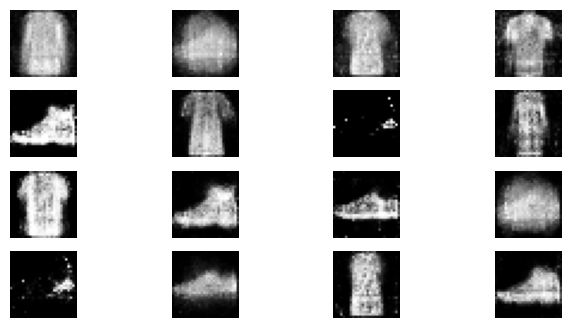

 84%|████████▍ | 42/50 [03:59<00:46,  5.76s/it]

Time for epoch: 42 is 5.670239210128784 seconds
Training started with epoch 43 with 469 batches...
Epoch: 43: Generator loss:  1.853678, Discriminator loss:  0.618624, Real Score:  0.801415. Fake Score:  0.230449


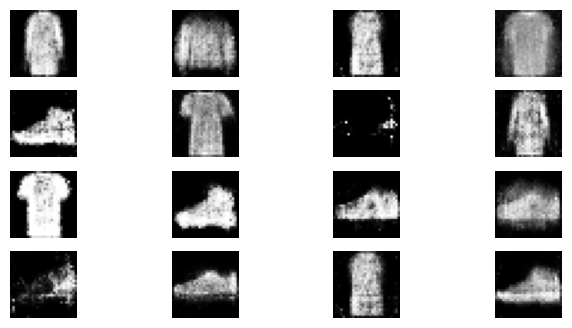

 86%|████████▌ | 43/50 [04:05<00:40,  5.77s/it]

Time for epoch: 43 is 5.798196315765381 seconds
Training started with epoch 44 with 469 batches...
Epoch: 44: Generator loss:  1.587356, Discriminator loss:  0.836708, Real Score:  0.773630. Fake Score:  0.292965


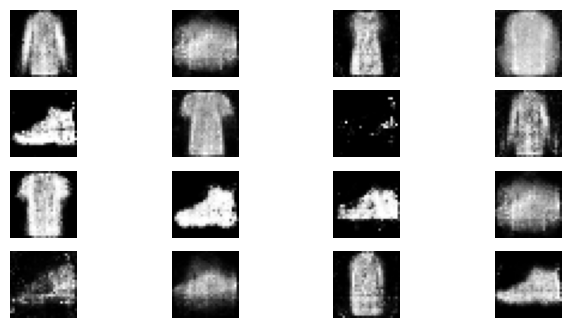

 88%|████████▊ | 44/50 [04:11<00:35,  5.86s/it]

Time for epoch: 44 is 6.06015419960022 seconds
Training started with epoch 45 with 469 batches...
Epoch: 45: Generator loss:  2.407180, Discriminator loss:  0.681312, Real Score:  0.801570. Fake Score:  0.172466


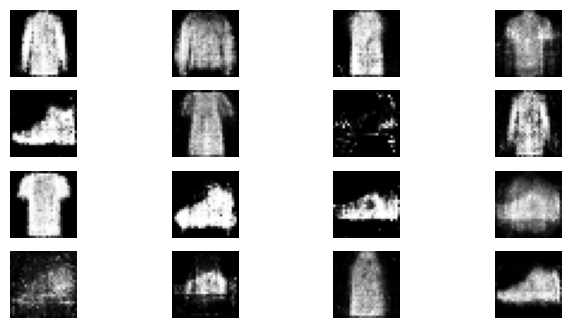

 90%|█████████ | 45/50 [04:17<00:29,  5.87s/it]

Time for epoch: 45 is 5.902080297470093 seconds
Training started with epoch 46 with 469 batches...
Epoch: 46: Generator loss:  2.180060, Discriminator loss:  0.787904, Real Score:  0.761515. Fake Score:  0.218341


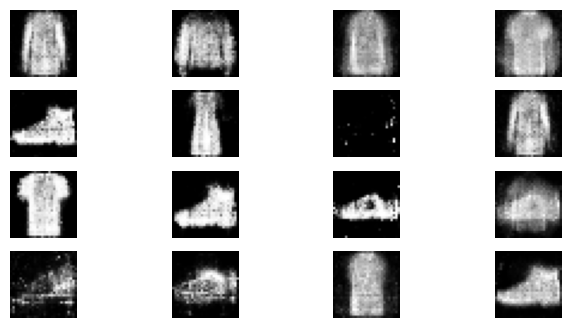

 92%|█████████▏| 46/50 [04:23<00:23,  5.80s/it]

Time for epoch: 46 is 5.636378526687622 seconds
Training started with epoch 47 with 469 batches...
Epoch: 47: Generator loss:  1.514804, Discriminator loss:  0.911119, Real Score:  0.718073. Fake Score:  0.290710


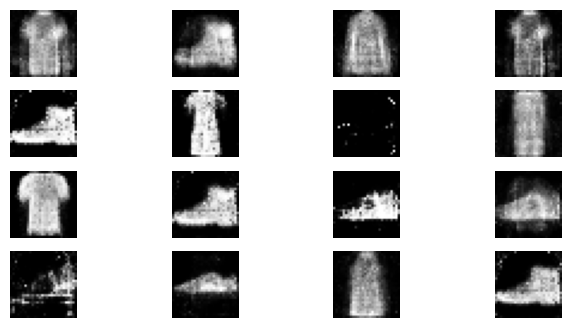

 94%|█████████▍| 47/50 [04:29<00:17,  5.99s/it]

Time for epoch: 47 is 6.416420221328735 seconds
Training started with epoch 48 with 469 batches...
Epoch: 48: Generator loss:  1.235492, Discriminator loss:  1.111769, Real Score:  0.698267. Fake Score:  0.379109


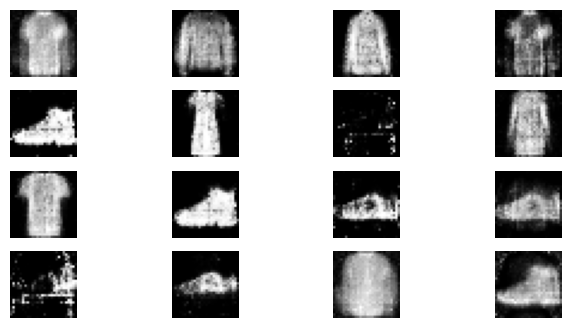

 96%|█████████▌| 48/50 [04:34<00:11,  5.80s/it]

Time for epoch: 48 is 5.363001108169556 seconds
Training started with epoch 49 with 469 batches...
Epoch: 49: Generator loss:  2.004834, Discriminator loss:  0.878001, Real Score:  0.708944. Fake Score:  0.247220


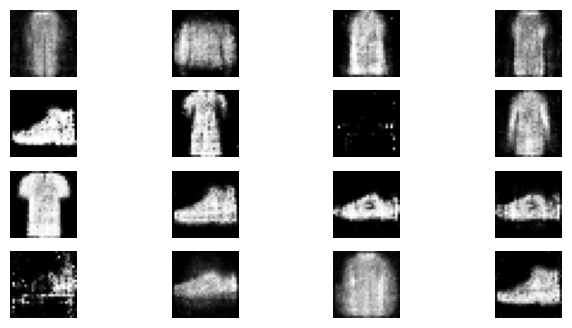

 98%|█████████▊| 49/50 [04:40<00:05,  5.75s/it]

Time for epoch: 49 is 5.627393007278442 seconds
Training started with epoch 50 with 469 batches...
Epoch: 50: Generator loss:  1.681111, Discriminator loss:  1.219396, Real Score:  0.665762. Fake Score:  0.304044


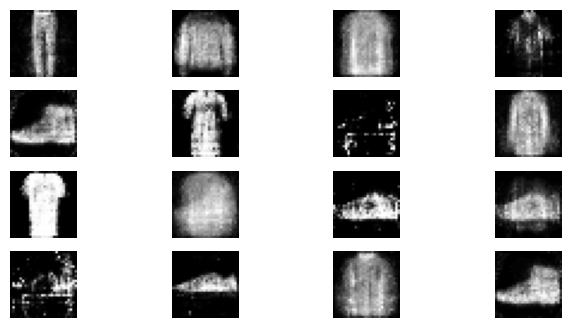

100%|██████████| 50/50 [04:46<00:00,  5.72s/it]

Time for epoch: 50 is 5.650602579116821 seconds


In [143]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs=epochs)

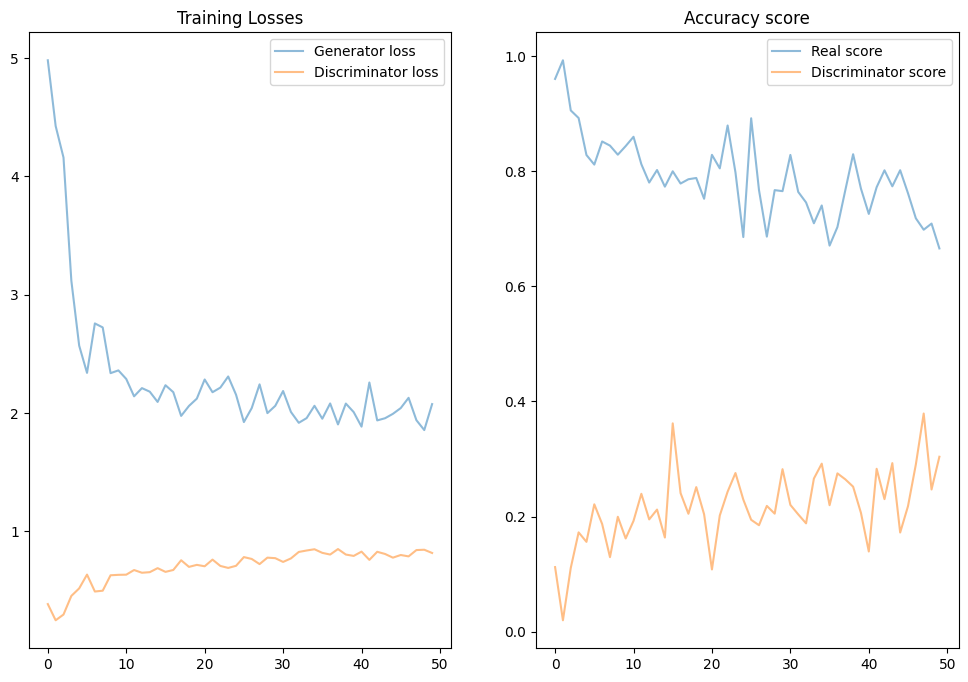

In [144]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.plot(gen_loss_epochs, label="Generator loss", alpha=0.5)
ax1.plot(disc_loss_epochs, label="Discriminator loss", alpha=0.5)
ax1.legend()

ax1.set_title("Training Losses")
ax2.plot(real_score_list, label="Real score", alpha=0.5)
ax2.plot(fake_score_list, label="Discriminator score", alpha=0.5)
ax2.set_title("Accuracy score")

ax2.legend()

